## Assignment 2: $k$ Nearest Neighbor

### Do any four.

**Q1.** Please answer the following questions.
1. What is the difference between regression and classification?
2. What is a confusion table/matrix? What does it help us understand about a model's performance?
3. What is Accuracy? Why might it not be entirely sufficient to evaluate a classifer's predictive performance?
4. What does the root mean squared error quantify about a particular model?
5. What are overfitting and underfitting?
6. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or RMSE on the test set, improve model performance?
7. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.

**Question 1**

1. Regression predicts a continuous numeric value while classification predicts discrete categorical outcomes.

2. Confusion matrix is a table of actual vs predicted classes. It shows where the model is right and which classes it confuses. It helps you see class by class performance.

3. Accuracy is defined as the number of correct divided by the total. t can be misleading with imbalanced classes since if you guess the class with the majority amount, it hides which type of error the model makes.

4. RMSE measures the typical size of prediction errors in the units of the outcome. It penalizes larger errors more because errors are squared.

5. Overfitting happens when a model learns the training data too closely, including noise, so it performs very well on the training set but worse on new test data; in kNN this often occurs when k is too small because predictions depend heavily on a few nearby points. Underfitting happens when a model is too simple to capture the real pattern in the data, so it performs poorly on both the training and test sets; in kNN this often occurs when k is too large because averaging over many neighbors “smooths out” important differences.

6. Splitting data into training and testing sets improves performance because it lets you evaluate how well the model generalizes to unseen data. If you choose k based only on training performance, you may pick a value that fits noise. By selecting k using accuracy or RMSE on the test set, you choose the value that works best on data the model did not train on, which usually leads to better real-world predictions.

7. In classification, predicting a single class label is simple and easy to act on, but it hides uncertainty. The model might be barely confident or extremely confident and you wouldn’t know. Predicting a probability distribution over classes provides a better confidence measure, which helps with decision making, thresholds, and risk management, but it can be more complex to use and the probabilities may not be perfectly calibrated.


**Q2.** This is a case study on $k$ nearest neighbor classification, using the `land_mines.csv` data.

The data consists of a label, `mine_type`, taking integer values 1 to 5, and three properties of the mine, `voltage`, `height` and `soil`. We want to predict the kind of mine from data about it. Imagine working for the DOD or a humanitarian aid agency, trying to help people remove land mines more safely.

1. Load the data. Perform some EDA, summarizing the target label and the relationships between the features (e.g. scatterplots, describe tables).
2. Split the sample 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be, in my experience: Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion table for your best model, comparing predicted and actual class label on the test set. How accurate is it? Where is performance more or less accurate?
5. Notice that you can have a lot of accurate predictions for a given type of mine, but still make a lot of mistakes. Please explain how you'd advise someone to actually use this predictive model in practice, given the errors that it tends to make.

In [21]:
#Question 2.1
import urllib.request
import os
import zipfile
import os

def download_data(force=False):
    """Download and extract course data from Zenodo."""

    zip_path = 'data.zip'
    data_dir = './data'

    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/18235955/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")

    if not os.path.exists(data_dir) or force:
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")

    return data_dir

if __name__ == "__main__":
    download_data()


In [22]:
#Question 2.1
import pandas as pd
df = pd.read_csv('/content/data/land_mines.csv')
df.head()


,voltage,height,soil,mine_type
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1


In [23]:
#Question 2.1
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())

print("\nMine type counts:")
counts = df["mine_type"].value_counts().sort_index()
print(counts)

print("\nMine type proportions:")
print((counts / counts.sum()).round(3))

print("\nDescribe features:")
print(df[["voltage","height","soil"]].describe().round(4))


Shape: (338, 4)

Missing values:
 voltage      0
height       0
soil         0
mine_type    0
dtype: int64

Mine type counts:
mine_type
1    71
2    70
3    66
4    66
5    65
Name: count, dtype: int64

Mine type proportions:
mine_type
1    0.210
2    0.207
3    0.195
4    0.195
5    0.192
Name: count, dtype: float64

Describe features:
        voltage    height      soil
count  338.0000  338.0000  338.0000
mean     0.4306    0.5089    0.5036
std      0.1958    0.3060    0.3442
min      0.1977    0.0000    0.0000
25%      0.3097    0.2727    0.2000
50%      0.3595    0.5455    0.6000
75%      0.4826    0.7273    0.8000
max      1.0000    1.0000    1.0000


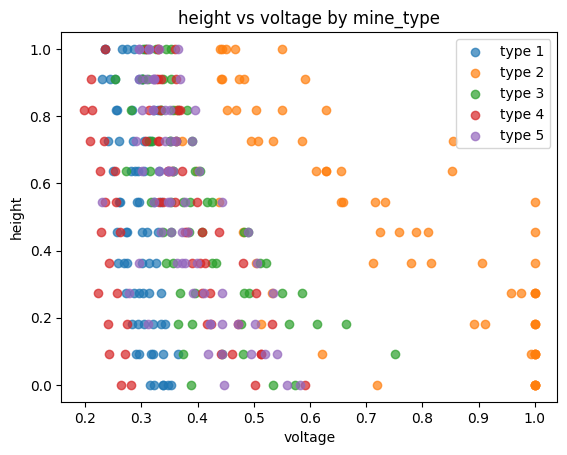

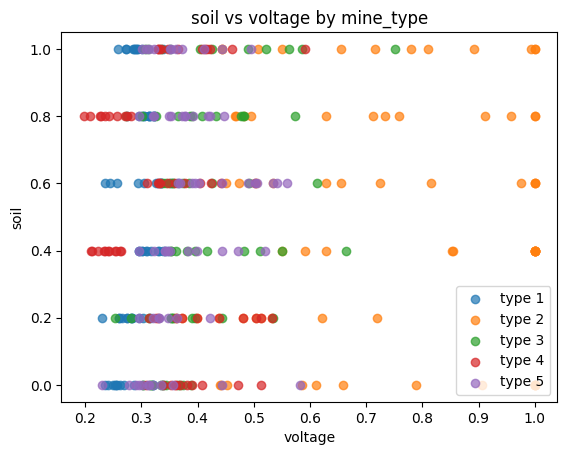

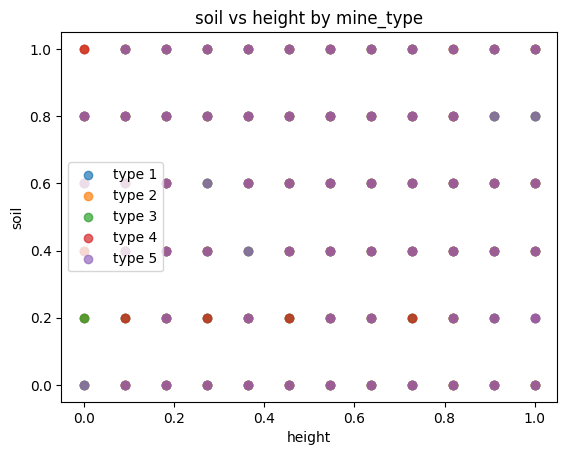

In [24]:
#Question 2.1
import matplotlib.pyplot as plt

pairs = [("voltage","height"), ("voltage","soil"), ("height","soil")]

for x, y in pairs:
    plt.figure()
    for c in sorted(df["mine_type"].unique()):
        sub = df[df["mine_type"] == c]
        plt.scatter(sub[x], sub[y], alpha=0.7, label=f"type {c}")
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f"{y} vs {x} by mine_type")
    plt.legend()
    plt.show()


In [25]:
#Question 2.2
from sklearn.model_selection import train_test_split

X = df[["voltage","height","soil"]]
y = df["mine_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=100, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("\nTrain class counts:\n", y_train.value_counts().sort_index())
print("\nTest class counts:\n", y_test.value_counts().sort_index())


Train: (169, 3) Test: (169, 3)

Train class counts:
 mine_type
1    35
2    35
3    33
4    33
5    33
Name: count, dtype: int64

Test class counts:
 mine_type
1    36
2    35
3    33
4    33
5    32
Name: count, dtype: int64


In [26]:
#2.3
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
u_train = scaler.fit_transform(X_train)   # fit on train
u_test  = scaler.transform(X_test)        # transform test using train scaler

import numpy as np
from sklearn.neighbors import KNeighborsClassifier

k_grid = np.array([(2*k + 3) for k in range(0, 75)])  # 3..151 odd ks
test_accs = []
train_accs = []

for k in k_grid:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(u_train, y_train)

    test_accs.append(model.score(u_test, y_test))
    train_accs.append(model.score(u_train, y_train))

test_accs = np.array(test_accs)
train_accs = np.array(train_accs)

k_optimal = k_grid[np.argmax(test_accs)]
acc_optimal = test_accs.max()

print("k* =", k_optimal, " | best test accuracy =", round(float(acc_optimal), 3))


k* = 3  | best test accuracy = 0.467


Question 2.3:

To compute 'k', I tried many odd k’s, trained kNN on the training set, computed test accuracy for each k, and picked the k with the highest test accuracy.

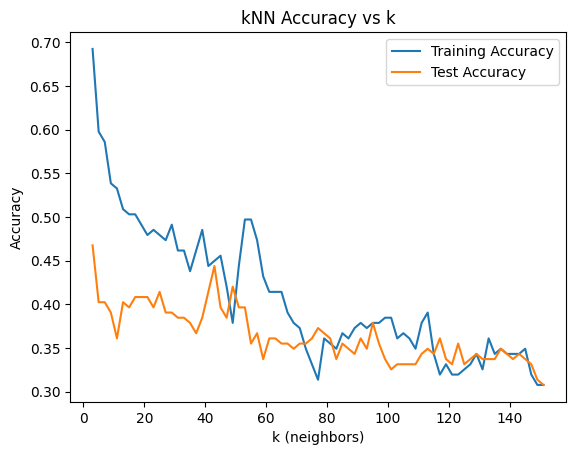

In [27]:
#2.3

plt.figure()
plt.plot(k_grid, train_accs, label="Training Accuracy")
plt.plot(k_grid, test_accs, label="Test Accuracy")
plt.xlabel("k (neighbors)")
plt.ylabel("Accuracy")
plt.title("kNN Accuracy vs k")
plt.legend()
plt.show()


Test accuracy: 0.467


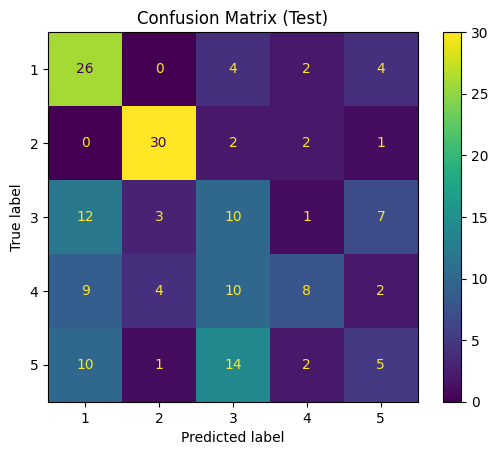

In [9]:
#2.4
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

best_model = KNeighborsClassifier(n_neighbors=int(k_optimal))
best_model.fit(u_train, y_train)
y_hat = best_model.predict(u_test)

acc = accuracy_score(y_test, y_hat)
print("Test accuracy:", round(acc, 3))

cm = confusion_matrix(y_test, y_hat, labels=sorted(y.unique()))
disp = ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique()))
disp.plot()
plt.title("Confusion Matrix (Test)")
plt.show()


Question 2.4:

the model achieved a test accuracy of 0.467, meaning it correctly classified about 46.7% of mines in the test set. From the confusion matrix, the model is most accurate for mine type 2 with 30 correct predictions and also fairly accurate for mine type 1 with 26 correct predictions. In contrast, performance is much weaker for mine types 3, 4, and 5, which are often confused with each other

In [31]:
#2.5
probs = best_model.predict_proba(u_test)
conf = probs.max(axis=1)

y_hat = best_model.predict(u_test) # Recompute y_hat for the current problem's test set

threshold = 0.80
use_model = conf >= threshold

print("Share high-confidence:", round(use_model.mean(), 3))
print("Accuracy on high-confidence subset:", round(accuracy_score(y_test[use_model], y_hat[use_model]), 3))
print("Share flagged for review:", round((~use_model).mean(), 3))

Share high-confidence: 0.154
Accuracy on high-confidence subset: 0.885
Share flagged for review: 0.846


Question 2.5:

Because the model only gets about 46.7% accuracy overall, it should not be used as a decision maker. Use it as a supporting tool. Trust predictions only when the model is high-confidence, since those cases were much more accurate. 88.5% in our output above.. For the large set of lower confidence cases, treat the prediction as uncertain and you should probably escalate to additional inspection/testing methods or follow the most conservative safety protocols.

**Q3.** This question is a case study for $k$ nearest neighbor regression, using the `USA_cars_datasets.csv` data.

The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for hyper-parameter selection and evaluation.
4. Use the $k$-NN algorithm and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the mean squared error and print a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

In [32]:
#Question 3.1
df = pd.read_csv("/content/data/USA_cars_datasets.csv")

df = df[["price", "year", "mileage"]]
print(df.head())
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())
df = df.dropna()
print("\nShape after dropna:", df.shape)


   price  year  mileage
0   6300  2008   274117
1   2899  2011   190552
2   5350  2018    39590
3  25000  2014    64146
4  27700  2018     6654
Shape: (2499, 3)

Missing values:
 price      0
year       0
mileage    0
dtype: int64

Shape after dropna: (2499, 3)


In [33]:
#Question 3.2

X = df[["year", "mileage"]]
y = df["price"]

scaler = MinMaxScaler()
u = scaler.fit_transform(X)   # normalized features


In [34]:
#Question 3.3

u_train, u_test, y_train, y_test = train_test_split(
    u, y, test_size=0.2, random_state=100
)

len(y_train), len(y_test)


(1999, 500)

k =   3 | Test MSE = 126,446,573.22


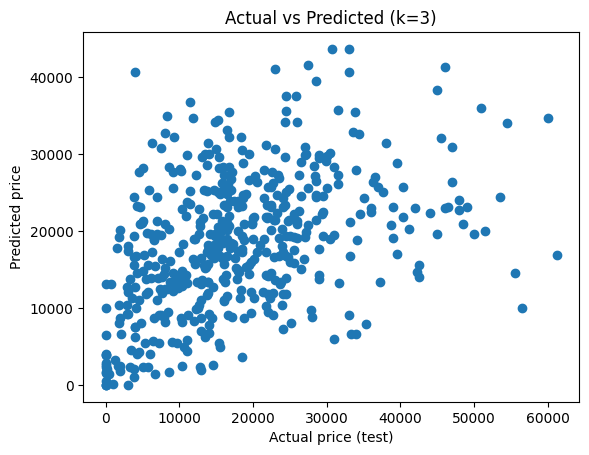

k =  10 | Test MSE = 110,802,185.59


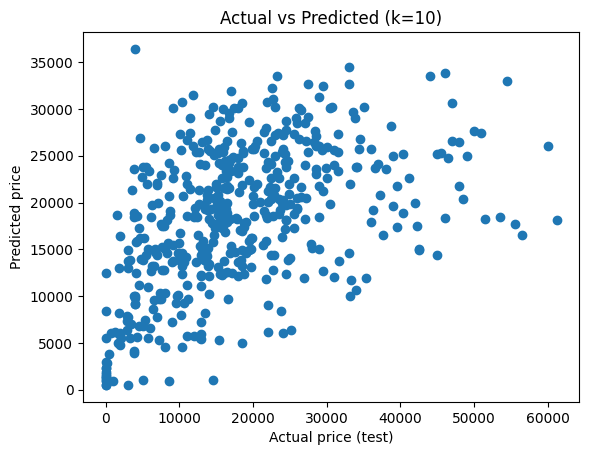

k =  25 | Test MSE = 103,170,457.85


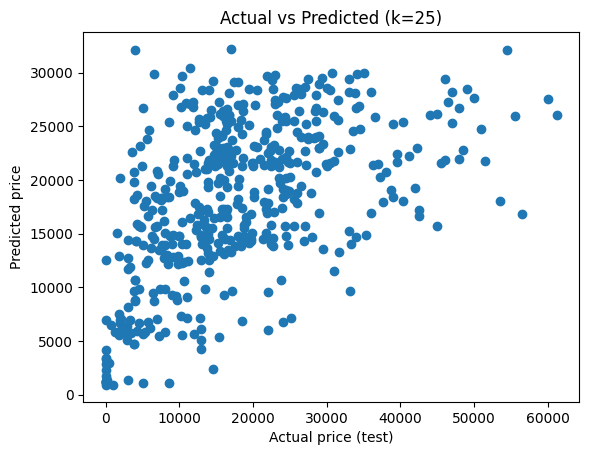

k =  50 | Test MSE = 99,694,130.38


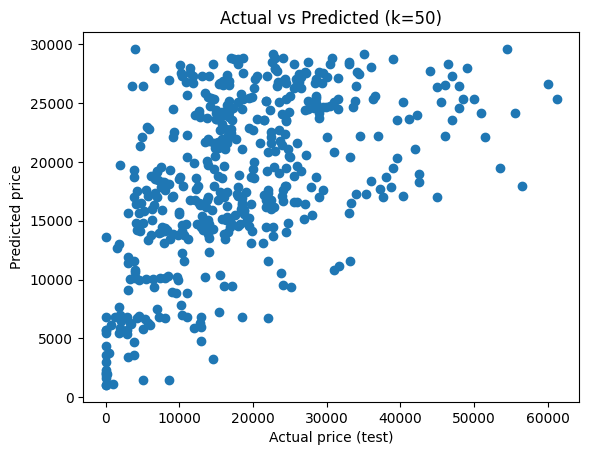

k = 100 | Test MSE = 98,271,058.96


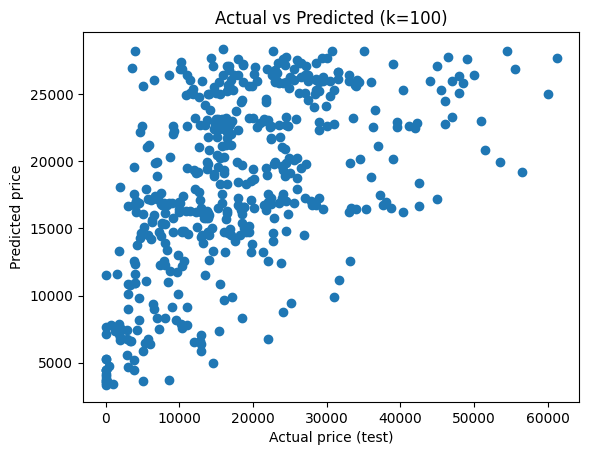

k = 300 | Test MSE = 100,477,298.91


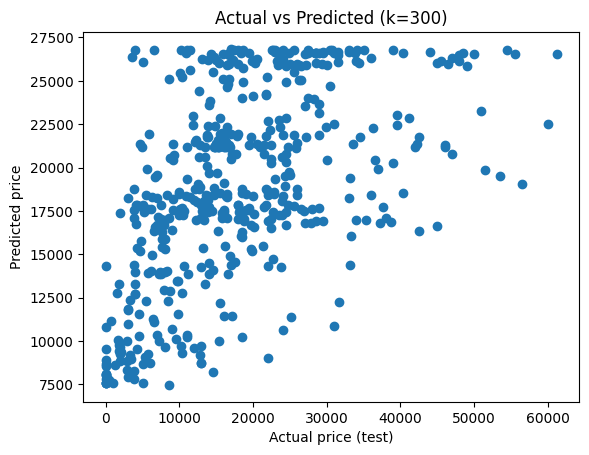

In [35]:
#Question 3.4
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

k_list = [3, 10, 25, 50, 100, 300]
mse_list = []

for k in k_list:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(u_train, y_train)

    y_hat = model.predict(u_test)
    mse = mean_squared_error(y_test, y_hat)
    mse_list.append(mse)

    print(f"k = {k:>3} | Test MSE = {mse:,.2f}")

    plt.figure()
    plt.scatter(y_test, y_hat)
    plt.xlabel("Actual price (test)")
    plt.ylabel("Predicted price")
    plt.title(f"Actual vs Predicted (k={k})")
    plt.show()


In [36]:
#Question 3.5
best_idx = int(np.argmin(mse_list))
k_star = k_list[best_idx]
best_mse = mse_list[best_idx]

print("Optimal k among the tested values:", k_star)
print("Lowest test MSE:", best_mse)


Optimal k among the tested values: 100
Lowest test MSE: 98271058.96092059


**Question 3.6**

As k increased from 3 to 100, the predictions became less noisy and the test MSE fell, meaning the model was reducing overfitting. When k got very large, predictions became too smoothed/averaged, so the plot compressed toward a middle price level. That’s underfitting, and you see it in the MSE rising again from k=100 to k=300.

**Q4.** This question is a case study for $k$ nearest neighbor regression, using the `heart_failure_clinical_records_dataset.csv` data.

The data for the question include:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- death event: if the patient deceased during the follow-up period (boolean)

1. Load the `./data/heart_failure_clinical_records_dataset.csv`. Are there any `NA`'s to handle? use `.drop()` to remove `time` from the dataframe.
2. Make a correlation matrix. What variables are strongly associated with a death event?
3. For the dummy variables `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, and `smoking`, compute a summary table of `DEATH_EVENT` grouped by the variable. For which variables does a higher proportion of the population die when the variable takes the value 1 rather than 0?
4. On the basis of your answers from 2 and 3, build a matrix $X$ of the variables you think are most predictive of a death, and a variable $y$ equal to `DEATH_EVENT`.
5. Maxmin normalize all of the variables in `X`.
6. Split the sample into ~80% for training and ~20% for evaluation. (Try to use the same train/test split for the whole question, so that you're comparing apples to apples in the questions below.).
7. Determine the optimal number of neighbors for a $k$-NN classification or regression for the variables you selected.
8. OK, do steps 5 through 7 again, but use all of the variables (except `time`). Which model has the best Mean Squared Error? Which would you prefer to use in practice, if you had to predict `DEATH_EVENT`s? If you play with the selection of variables, how much does the RMSE change for your fitted model on the test data? Are more variables always better? Explain your findings.

**Q5.** This is a case study on $k$ nearest neighbor classification, using the `animals.csv` data.

The data consist of a label, `class`, taking integer values 1 to 7, the name of the species, `animal`, and 16 characteristics of the animal, including `hair`, `feathers`, `milk`, `eggs`, `airborne`, and so on.

1. Load the data. For each of the seven class labels, print the values in the class and get a sense of what is included in that group. Perform some other EDA: How big are the classes? How much variation is there in each of the features/covariates? Which variables do you think will best predict which class?
2. Split the data 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be. Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Using all of the variables, build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion matrix for the optimal model, comparing predicted and actual class label on the test set. How accurate it is? Can you interpret why mistakes are made across groups?
5. Use only `milk`, `aquatic`, and `airborne` to train a new $k$-NN classifier. Print your confusion table. Mine does not predict all of the classes, only a subset of them. To see the underlying proportions/probabilities, use `model.predict_proba(X_test.values)` to predict probabilities rather than labels for your `X_test` test data for your fitted `model`. Are all of the classes represented? Explain your results.

**Q6.** This is a case study using $k$ nearest neighbor regression for imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to column filter the dataframe to those variables.
2. Set use `.isnull()` and `.loc` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.
3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.
4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)
5. Predict the missing ratings.
6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Describe what you see.

In [37]:
#Question 6.1
df0 = pd.read_csv("/content/data/airbnb_hw.csv")

df0 = df0.loc[:, ["Review Scores Rating", "Price", "Beds"]].copy()
df0.head()

,Review Scores Rating,Price,Beds
0,NaN,145,1.0
1,NaN,37,1.0
2,NaN,28,1.0
3,NaN,199,3.0
4,96.0,549,3.0


In [38]:
#Question 6.2
missing_mask = df0["Review Scores Rating"].isnull()

df_missing = df0.loc[missing_mask, :].copy()
df_known   = df0.loc[~missing_mask, :].copy()



In [39]:
#Question 6.3
df_known = df_known.dropna(axis=0, how="any").copy()

df_missing = df_missing.dropna(subset=["Price","Beds"]).copy()



In [41]:

df_known["Price"] = df_known["Price"].astype(str).str.replace(",", "", regex=False).astype(float)
df_known["Beds"]  = pd.to_numeric(df_known["Beds"], errors="coerce")

X = df_known[["Price","Beds"]]
y = df_known["Review Scores Rating"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100
)

# scale (kNN uses distance, so scaling matters)
scaler = MinMaxScaler()
u_train = scaler.fit_transform(X_train)
u_test  = scaler.transform(X_test)

# choose k by minimizing test SSE
k_grid = np.arange(1, 101, 2)
test_sse = []

for k in k_grid:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(u_train, y_train)
    y_hat = model.predict(u_test)
    test_sse.append(np.sum((y_test - y_hat)**2))

k_star = k_grid[np.argmin(test_sse)]
best_sse = np.min(test_sse)

print("Best k:", k_star)
print("Best test SSE:", best_sse)

# refit best model
best_model = KNeighborsRegressor(n_neighbors=k_star).fit(u_train, y_train)


Best k: 99
Best test SSE: 337866.77053361904


In [43]:
#Question 6.5


df_missing["Price"] = df_missing["Price"].astype(str).str.replace(",", "", regex=False).astype(float)
df_missing["Beds"]  = pd.to_numeric(df_missing["Beds"], errors="coerce")

X_missing = df_missing[["Price", "Beds"]]
u_missing = scaler.transform(X_missing)

# Predict missing ratings
y_missing_hat = best_model.predict(u_missing)

# Save predictions back into df_missing
df_missing = df_missing.copy()
df_missing["Predicted Review Scores Rating"] = y_missing_hat

df_missing


,Review Scores Rating,Price,Beds,Predicted Review Scores Rating
0,NaN,145.0,1.0,94.121212
1,NaN,37.0,1.0,87.787879
2,NaN,28.0,1.0,85.888889
3,NaN,199.0,3.0,88.464646
13,NaN,68.0,1.0,92.616162
...,...,...,...,...
30473,NaN,300.0,5.0,90.323232
30474,NaN,125.0,2.0,91.767677
30475,NaN,80.0,1.0,91.383838
30476,NaN,35.0,1.0,87.636364


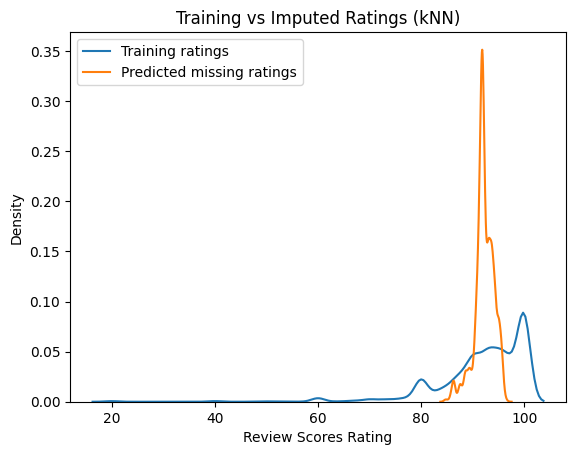

In [44]:
#Question 6.6
import seaborn as sns

sns.kdeplot(x=y_train, label="Training ratings")
sns.kdeplot(x=y_missing_hat, label="Predicted missing ratings")
plt.xlabel("Review Scores Rating")
plt.title("Training vs Imputed Ratings (kNN)")
plt.legend()
plt.show()


Question 6.6:

Both distributions are both mostly in the high 80s to 100 range.The orange predicted ratings curve is much more concentrated, meaning the model is giving very similar predicted scores for most missing listings. The training ratings curve on the other hand is more spread out and has more mass toward higher scores. So the imputed predicted ratings are less variable and look “shrunk toward the middle” compared to the training ratings.

**Q7.** Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and use $k$-NN to predict values (i.e. "see/read").

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a list of matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use the reshaped `X_test` and `y_test` data to create a $k$-nearest neighbor classifier of digit. What is the optimal number of neighbors $k$? If you can't determine this, play around with different values of $k$ for your classifier.
5. For the optimal number of neighbors, how well does your predictor perform on the test set? Report the accuracy, compute a confusion matrix, and explain your findings.
6. For your confusion matrix, which mistakes are most likely? Do you find any interesting patterns?
7. So, this is how computers "see." They convert an image into a matrix of values, that matrix becomes a vector in a dataset, and then we deploy ML tools on it as if it was any other kind of tabular data. To make sure you follow this, invent a way to represent a color photo in matrix form, and then describe how you could convert it into tabular data. (Hint: RGB color codes provide a method of encoding a numeric value that represents a color.)